In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("LinkedIn_Visualizations").getOrCreate()

# LOAD the cleaned dataset from Parquet
# Change this to your file path which is beign generated from the data cleaning part
jobs_feature_df = spark.read.parquet("/content/part-00000-011679fe-fabd-42d8-bff3-b84647be7521-c000.snappy.parquet")

cols_needed = [
    "title",
    "job_city",
    "job_state",
    "job_country",
    "salary_annual_usd",
    "formatted_experience_level",
    "work_type",
    "skills",
    "views",
    "applies"
]

df_vis_spark = (
    jobs_feature_df
    .select(*cols_needed)
    .where(F.col("salary_annual_usd").isNotNull())
    .limit(20000)
)

df_vis = df_vis_spark.toPandas()

df_vis.head(), df_vis.shape

(                                               title  \
 0  Federal IT Call Center Technician (TS/SCI, Ful...   
 1        Monitoring Tools Engineer, Secret Clearance   
 2       Electrical/Hardware Design Engineer Graduate   
 3                        Software Engineering Intern   
 4        Product Master Data IT - Functional Analyst   
 
                     job_city      job_state job_country  salary_annual_usd  \
 0                San Antonio             TX        None           142000.0   
 1                   Maryland  United States          US           143750.0   
 2                     Spring             TX        None            96750.0   
 3  Greater Fort Collins Area           None        None            82420.0   
 4                     Durham             NC        None           163750.0   
 
   formatted_experience_level  work_type  \
 0                       None  FULL_TIME   
 1                       None  FULL_TIME   
 2                       None  FULL_TIME   
 3  

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style="whitegrid")


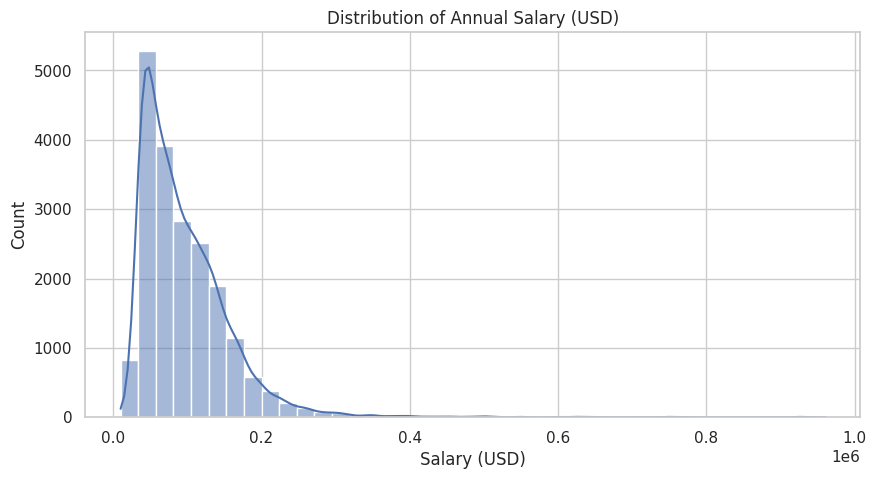

In [3]:
plt.figure(figsize=(10,5))
sns.histplot(df_vis["salary_annual_usd"], kde=True, bins=40)
plt.title("Distribution of Annual Salary (USD)")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.show()

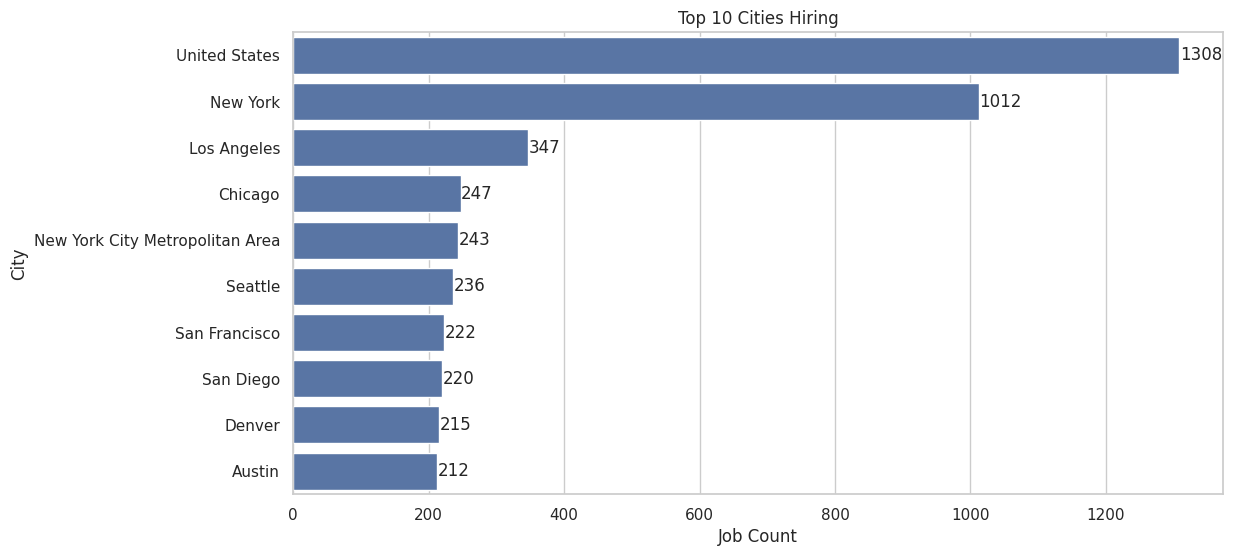

In [4]:
top_cities = df_vis["job_city"].value_counts().head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=top_cities.values, y=top_cities.index)

for i, value in enumerate(top_cities.values):
    ax.text(value + 1, i, str(value), va='center', fontsize=12)

plt.title("Top 10 Cities Hiring")
plt.xlabel("Job Count")
plt.ylabel("City")
plt.show()

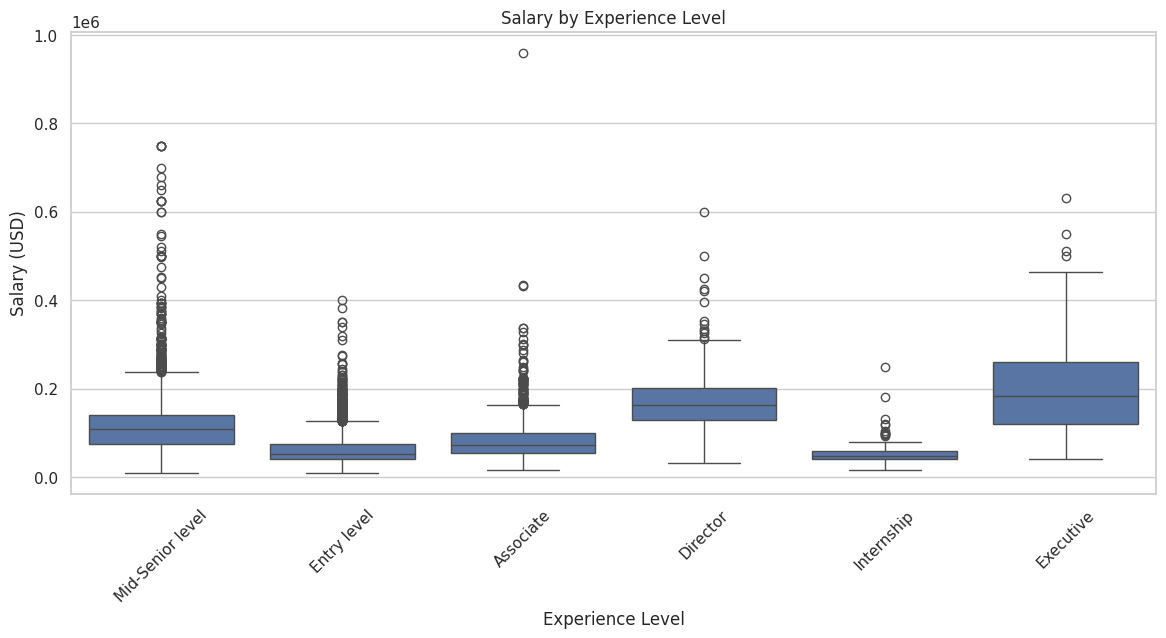

In [5]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_vis, x="formatted_experience_level", y="salary_annual_usd")
plt.xticks(rotation=45)
plt.title("Salary by Experience Level")
plt.xlabel("Experience Level")
plt.ylabel("Salary (USD)")
plt.show()

In [6]:
# Create remote_type classification from work_type
df_vis['remote_type'] = df_vis['work_type'].apply(
    lambda x: 'Remote' if pd.notna(x) and 'REMOTE' in str(x).upper()
    else 'Hybrid' if pd.notna(x) and 'HYBRID' in str(x).upper()
    else 'Onsite'
)

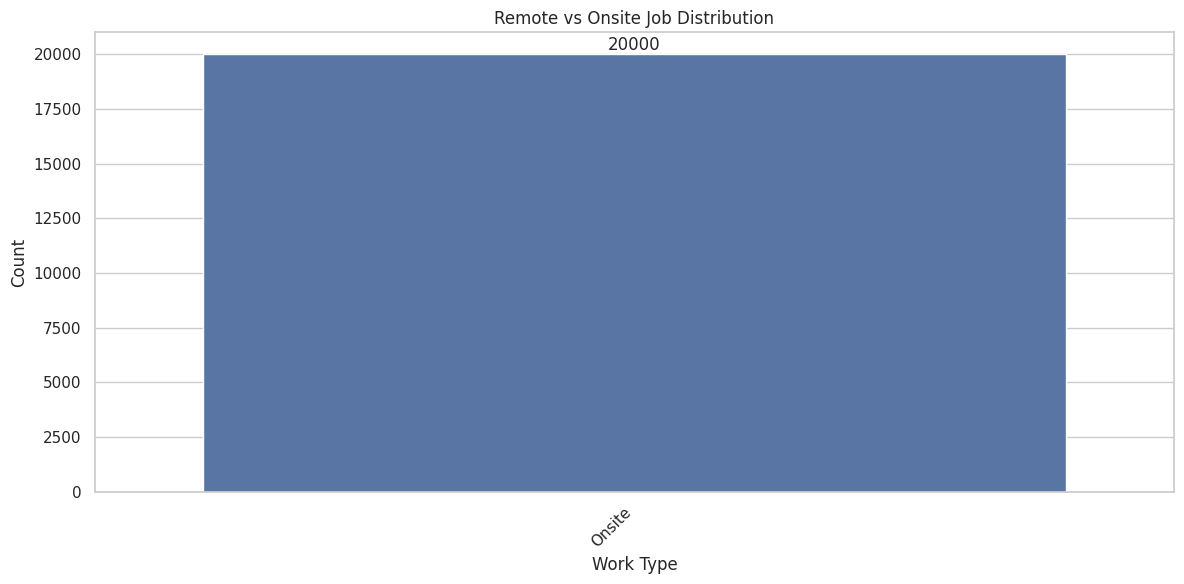

In [7]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="remote_type", data=df_vis)

for container in ax.containers:
    ax.bar_label(container)

plt.title("Remote vs Onsite Job Distribution")
plt.xlabel("Work Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

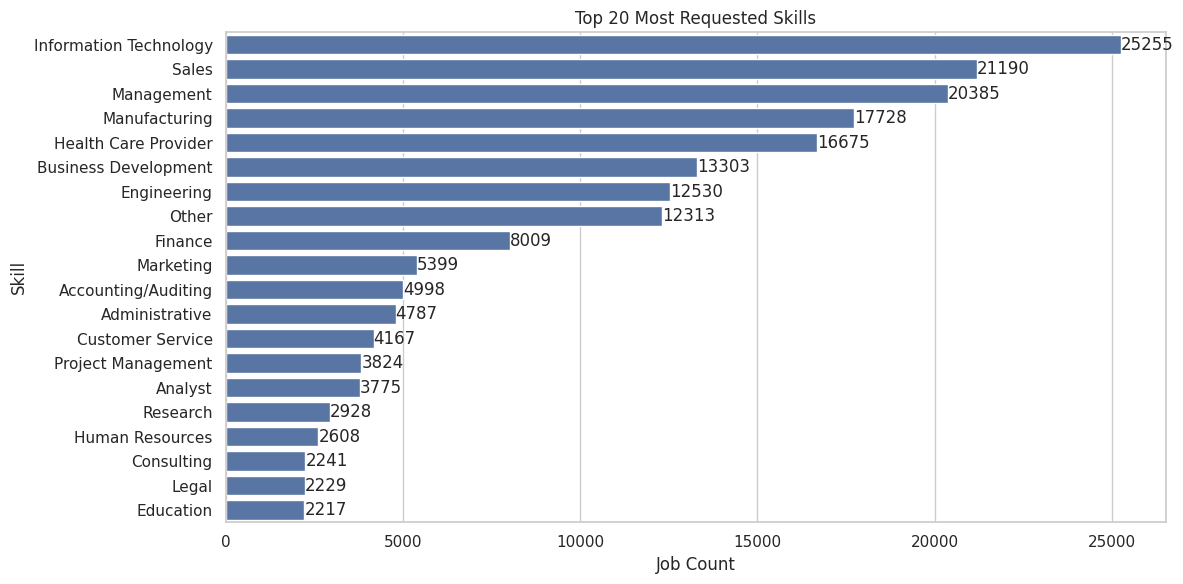

In [8]:
from pyspark.sql.functions import explode_outer

skills_spark = jobs_feature_df.select(explode_outer("skills").alias("skill"))
skills_top = (
    skills_spark.groupBy("skill").count().orderBy(F.desc("count")).limit(20)
).toPandas()

plt.figure(figsize=(12,6))
ax = sns.barplot(data=skills_top, x="count", y="skill")  # First create ax

ax.bar_label(ax.containers[0])

plt.title("Top 20 Most Requested Skills")
plt.xlabel("Job Count")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

In [9]:
fig = px.box(
    df_vis,
    x="formatted_experience_level",
    y="salary_annual_usd",
    title="Interactive: Salary by Experience Level",
    color="formatted_experience_level"
)
fig.show()

In [10]:
fig = px.scatter(
    df_vis,
    x="views",
    y="salary_annual_usd",
    color="formatted_experience_level",
    hover_data=["title", "job_city"],
    title="Salary vs Job Post Views"
)
fig.show()